In [1]:
drug = "Acetaminophen"

In [2]:
#imports 
import multiprocessing

import feather
import matplotlib as mpt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV


%matplotlib inline
%config InlineBackend.figure_format = 'retina'




ROOT = "/Users/payalchandak/Not On Dropbox/Data/Sex Demographics/" 

In [3]:
df_aeolus = pd.read_feather(ROOT + "AEOLUS/clean_withRank.tsv.feather")
df_PSM_all = pd.read_feather(ROOT+'PSM/Generic Matrix.feather').set_index('ID')
df_PSM_all.index.name = 'ID'

In [4]:
df_PSM_all_all.head()

,Age,Sex,NumDrugs,Amoxicillin,Simvastatin,Nitroglycerin,Diclofenac,Prednisolone,Aspirin,Cisplatin,...,Grape.Seed.Extract,Beractant,Urofollitropin,Cetrorelix,Icatibant,Mipomersen,Betamethasone./.Clotrimazole.Topical.Ointment,Nystatin./.Triamcinolone.Topical.Ointment,Clodronic.Acid,Clofazimine
ID,,,,,,,,,,,,,,,,,,,,,
99376162,51,M,1,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4329751,52,M,3,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4338498,60,F,1,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4546516,36,F,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4737732,39,M,10,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
#getting df_PSM for case (exposed to drug) & control (unexposed) cohorts
cases = df_PSM_all.query('{}==1'.format(drug))
controls = df_PSM_all.query('{}==0'.format(drug))

In [7]:
#getting COV (age, num drugs, concomittant > 1%)

covariates = (cases>0).astype(np.int8).mean(axis=0).ge(0.01)
covariates = np.array(covariates.index)[np.array(covariates.values)].tolist()
covariates.remove(drug)
covariates.remove('Sex')

In [8]:
# setting x & y for logistic regression
# x: covariates 
# y: drug

y = df_PSM_all.loc[:,[drug]]
y=y.values.reshape(1,-1)[0]
X = df_PSM_all.loc[:,covariates]

In [13]:
# making logistic regression model
# with cross validation, l2 penalty

model = LogisticRegressionCV(penalty='l2')
propensity = model.fit(X,y)
pscore = propensity.predict_proba(X)[:,1] 
df_PSM_all['Propensity'] = pscore

In [33]:
len([b for b in (np.abs(propensity.coef_[0])) if b > 0])

180

In [36]:
# cases/controls with propensity

cases = df_PSM_all.query('{}==1'.format(drug))
controls = df_PSM_all.query('{}==0'.format(drug))

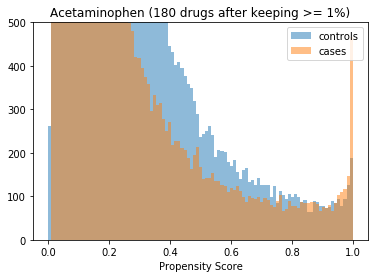

In [43]:
# hist 

bins = np.linspace(0, 1, 100)
plt.hist(controls.Propensity, bins, alpha=0.5, label='controls')
plt.hist(cases.Propensity, bins, alpha=0.5, label='cases')
plt.ylim(0,500)
plt.title(drug+" (180 drugs after keeping >= 1%)")
plt.xlabel("Propensity Score")
plt.legend(loc='upper right')
plt.show()

In [44]:
def getSensSpec(threshold): 
    TP, FN, TN, FP = 0, 0, 0, 0
    
    for idx, data in df_PSM_all.loc[:,[drug,'Propensity']].iterrows():
        pscore = data.get('Propensity')
        drugVal = data.get(drug)
        if (drugVal):
            if(pscore>=threshold):
                TP+=1
            else:
                FN+=1
        else:
            if(pscore<=threshold):
                TN+=1
            else:
                FP+=1
    
    sens = TP/(TP+FN)
    spec = TN/(TN+FP)
    return[threshold, sens, 1-spec]

In [45]:
# QUICK ROC ~ multiprocess 

thresholds = np.linspace(0,1,11)
PROCESSES = 4
pool = multiprocessing.Pool(processes=PROCESSES)
result = pool.map(getSensSpec, thresholds)
pool.close()
names = ["Threshold", "Sensitivity", "1 - Specificity"]
ROC_result = pd.DataFrame(data=result, columns=names)

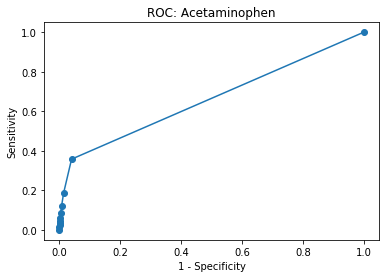

In [46]:
# PLOT ROC 

plt.plot( '1 - Specificity', 'Sensitivity', data=ROC_result, marker='o')
plt.title("ROC: "+drug)
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.show()

#sns.lmplot(data=ROC_result, x='', y='', fit_reg=False,)

In [47]:
cross_val_score
ROC AUC 

SyntaxError: invalid syntax (<ipython-input-47-18dc99f165f5>, line 2)

In [56]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(model, X, y,scoring='roc_auc'))

[0.86749043 0.85936651 0.85274957]


In [14]:
from sklearn.metrics import roc_auc_score
y_true = (df_PSM_all.get(drug)>0).astype(np.int8).values
y_scores = df_PSM_all.get('Propensity').values
roc_auc_score(y_true, y_scores)

0.8592862260094495

In [ ]:
df_PSM_all.get('Propensity').values

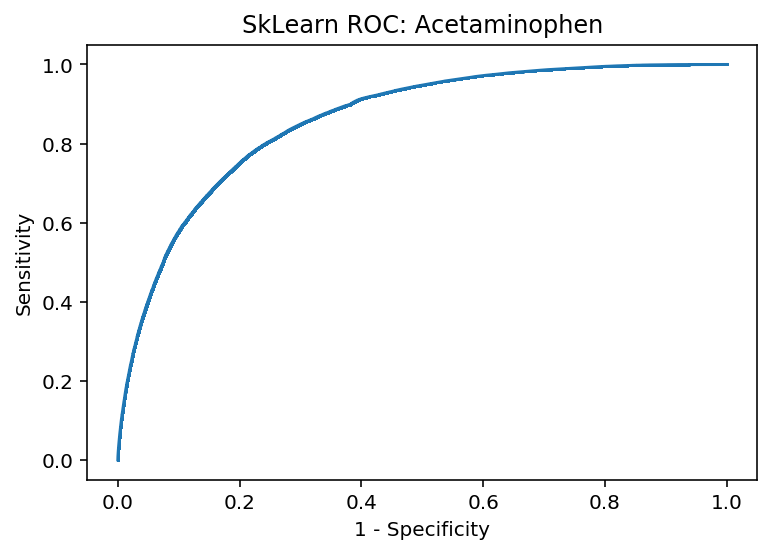

In [47]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
data=pd.DataFrame({'fpr':fpr, 'tpr':tpr})
plt.plot('fpr','tpr', data=data, marker='o',ms=0.1)   
plt.title("SkLearn ROC: "+drug)
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.show()

In [48]:
pkl_filename = ROOT+"PSM/Models/Acet_CV_1%.pkl" 

with open(pkl_filename, 'wb') as file:  
    pickle.dump(propensity, file)

In [50]:
ipython nbconvert --to script notebook.ipynb

SyntaxError: invalid syntax (<ipython-input-50-998efc52620d>, line 1)

In [ ]:
#imports 
import multiprocessing
import feather
import matplotlib as mpt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns
import pickle
import os
import shutil
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

drug = "Acetaminophen"

def log(message):
	LOG_PATH = Path("{}/log.txt".format(drug))
	message = str(message)+"\n"

	if LOG_PATH.is_file():
		with open(LOG_PATH, 'a') as log:
			log.write(message)
	else:
		with open(LOG_PATH, 'w') as log:
			log.write("New log created\n")
			log.write(message)

# Make new drug directory to store results 
if os.path.exists(drug):
	shutil.rmtree(drug)
os.mkdir(drug)


#read generic PSM matrix 
df_PSM_all = pd.read_feather('Generic Matrix.feather').set_index('ID')
df_PSM_all.index.name = 'ID'
log("Read general PSM data")

#getting df_PSM for case (exposed to drug) & control (unexposed) cohorts
cases = df_PSM_all.query('{}==1'.format(drug))
controls = df_PSM_all.query('{}==0'.format(drug))

#getting COV (age, num drugs, concomittant > 1%)
covariates = (cases>0).astype(np.int8).mean(axis=0).ge(0.01)
covariates = np.array(covariates.index)[np.array(covariates.values)].tolist()
covariates.remove(drug)
covariates.remove('Sex')
log("Got Covariates: "+str(covariates))

# setting x & y for logistic regression
# x: covariates 
# y: drug
y = df_PSM_all.loc[:,[drug]]
y=y.values.reshape(1,-1)[0]
X = df_PSM_all.loc[:,covariates]

# making logistic regression model
# with cross validation, l2 penalty

model = LogisticRegressionCV(penalty='l2')

propensity = model.fit(X,y)
log("Fitted LR model w CV, L2")

pkl_filename = "{}/LRCV.pkl".format(drug)
with open(pkl_filename, 'wb') as file:  
    pickle.dump(propensity, file)
log("Pickled")

retained = len([b for b in (np.abs(propensity.coef_[0])) if b > 0])
if (retained==len(covariates)):
	log("Covariates retained: ALL")
else:
	log("Covariates retained: "+str(retained))

pscore = propensity.predict_proba(X)[:,1] 
df_PSM_all['Propensity'] = pscore
log("pscores predicted & assigned")

df_PSM_all.loc[:,[drug,'Propensity']].reset_index().to_feather("{}/LRCV pscores.feather".format(drug))
log("pscores saved in dataframe")

# cases/controls with propensity
cases = df_PSM_all.query('{}==1'.format(drug))
controls = df_PSM_all.query('{}==0'.format(drug))

# hist 
bins = np.linspace(0, 1, 100)
plt.hist(controls.Propensity, bins, alpha=0.5, label='controls')
plt.hist(cases.Propensity, bins, alpha=0.5, label='cases')
plt.ylim(0,500)
plt.title("LRCV Histogram: "+drug)
plt.xlabel("Propensity Score")
plt.legend(loc='upper right')
plt.savefig("{}/Histogram".format(drug))
log("Hist made")
plt.close()

# METRICS AUROC
y_true = (df_PSM_all.get(drug)>0).astype(np.int8).values
y_scores = df_PSM_all.get('Propensity').values
AUROC_m = roc_auc_score(y_true, y_scores)
log("AUROC from SK metric: "+str(AUROC_m))

# CV AUROC
a, p, AUROC_CV = cross_val_score(model, X, y,scoring='roc_auc')
log("AUROC from CV: "+str(AUROC_CV))

# Plot ROC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
data=pd.DataFrame({'fpr':fpr, 'tpr':tpr})
plt.plot('fpr','tpr', data=data, marker='o',ms=0.1)   
plt.title("LRCV ROC: "+drug)
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.savefig("{}/ROC".format(drug))
log("ROC made")
plt.close()


